# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

In [1]:
# set up path to doogle drive folder with weights
weights_path = '/content/drive/MyDrive/Uni/MA/model_weights/'

##### Notebook settings

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

###### Install packages

In [3]:
!wget -nc https://raw.githubusercontent.com/Berenice2018/PySyft-Bc/master/syft/frameworks/torch/differential_privacy/pate.py

--2021-11-10 16:36:54--  https://raw.githubusercontent.com/Berenice2018/PySyft-Bc/master/syft/frameworks/torch/differential_privacy/pate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17194 (17K) [text/plain]
Saving to: ‘pate.py’

pate.py             100%[===================>]  16.79K  --.-KB/s    in 0.001s  

2021-11-10 16:36:55 (23.6 MB/s) - ‘pate.py’ saved [17194/17194]



In [4]:
!pip -q install git+https://github.com/tensorflow/privacy

     |████████████████████████████████| 4.0 MB 5.0 MB/s 


In [5]:
!pip -q install git+https://github.com/qubvel/classification_models.git

     |████████████████████████████████| 50 kB 3.2 MB/s 


##### Import libraries

In [6]:
import numpy as np
import seaborn as sns
import os, random, shutil
import matplotlib.pyplot as plt

from classification_models.tfkeras import Classifiers

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from pate import perform_analysis
from progressbar import ProgressBar

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.layers import Layer, Input, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SingleAttackResult
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia

In [7]:
ResNet50, _ = Classifiers.get('resnet50')

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [8]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
100% 780M/780M [00:03<00:00, 242MB/s]


##### Define constants

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
TEST_SPLIT = 0.15
VAL_SPLIT = 0.05
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SHAPE = [224, 224, 3] # original dataset image size is 299x299x3

# PATE parameters
TEACHER_NB = 25
TEACHER_EPOCHS = 100
STUDENT_EPOCHS = 20
STUDENT_DS_SIZE = 999
NOISE_SCALE = 33.0 # for epsilons of 0.1, 1, and 10 the laplace noise would have to be 2720, 278, and 33, respectively
NOISE_EPSILON = 1 / NOISE_SCALE

SAVE_TEACHERS = True

# Set fixed random seed
SEED = 42
random.seed(SEED)
random_state = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Data


### Create dataset

In [10]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [11]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [12]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [13]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [14]:
# create train-val-test split with 80-5-15
x_train, x_rest, y_train, y_rest = train_test_split(files, labels, test_size=VAL_SPLIT+TEST_SPLIT, random_state=random_state)
x_test, x_val, y_test, y_val = train_test_split(x_rest, y_rest, test_size=VAL_SPLIT/(VAL_SPLIT+TEST_SPLIT), random_state=random_state)

In [15]:
# split off student training data
student_split = STUDENT_DS_SIZE / len(y_train)
x_teacher, x_student, y_teacher, y_student = train_test_split(x_train, y_train, test_size=student_split, random_state=random_state)

In [16]:
TEACHER_IMG_COUNT = len(y_teacher)
STUDENT_IMG_COUNT = len(y_student)
VAL_IMG_COUNT = len(y_val)
TEST_IMG_COUNT = len(y_test)
print(
    'Train teachers: ' + str(TEACHER_IMG_COUNT) + ',',
    'Train student: ' + str(STUDENT_IMG_COUNT) + ',',
    'Val: ' + str(VAL_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train teachers: 6233, Train student: 999, Val: 452, Test: 1356


In [17]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [18]:
TEACHER_DISTRIBUTION = get_distribution(y_teacher)
STUDENT_DISTRIBUTION = get_distribution(y_student)
VAL_DISTRIBUTION = get_distribution(y_val)
TEST_DISTRIBUTION = get_distribution(y_test)
print('teacher train set: ', TEACHER_DISTRIBUTION)
print('student train set: ', STUDENT_DISTRIBUTION)
print('val set: ', VAL_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

teacher train set:  {'normal': 3746, 'COVID-19': 2487}
student train set:  {'normal': 593, 'COVID-19': 406}
val set:  {'normal': 272, 'COVID-19': 180}
test set:   {'normal': 813, 'COVID-19': 543}


###### Dataset partition for teachers

In [19]:
def partition_dataset(x, y, nb_teachers, teacher_id):
    # Sanity checks
    assert len(x) == len(y)
    assert int(teacher_id) < int(nb_teachers)

    # This will floor the possible number of batches
    part_len = int(len(x) / nb_teachers)
    assert part_len >= BATCH_SIZE

    # Compute start, end indices of partition
    start = teacher_id * part_len
    end = (teacher_id+1) * part_len

    if teacher_id == nb_teachers-1:
        end = len(x)

    # Slice partition off
    train_partition = (x[start:end], y[start:end])

    return train_partition

In [20]:
teacher_data = [partition_dataset(x_teacher, y_teacher, TEACHER_NB, teacher_id) for teacher_id in range(TEACHER_NB)]
print("Teacher partitions: " + str(len(teacher_data)))
print("Length first train: " + str(len(teacher_data[0][1])))
print("Length last train: " + str(len(teacher_data[-1][1])))

Teacher partitions: 25
Length first train: 249
Length last train: 257


###### Create tensors

In [21]:
# build tensorflow datasets
teacher_files = []
for teacher_id in range(TEACHER_NB):
    train_data = teacher_data[teacher_id]
    teacher_files.append(tf.data.Dataset.from_tensor_slices(train_data))

train_files = tf.data.Dataset.from_tensor_slices((x_teacher, y_teacher))
student_files = tf.data.Dataset.from_tensor_slices((x_student, y_student))
val_files = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [22]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [23]:
teacher_sets = []
for teacher_id in range(TEACHER_NB):
    train_file = teacher_files[teacher_id]
    teacher_sets.append(train_file.map(get_img, num_parallel_calls=AUTOTUNE))

train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
student_ds = student_files.map(get_img, num_parallel_calls=AUTOTUNE)
val_ds = val_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing

In [24]:
preprocessing = Sequential([
  Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
  Rescaling(scale=1./255)
])

###### Define data augmentation

In [25]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [26]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [27]:
data_augmentation = Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare batches

In [28]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [29]:
# batch datasets
# teachers
TEACHER_IMG_CNTS = []
teacher_batched = []
for teacher_id in range(TEACHER_NB):
    teacher_ds = teacher_sets[teacher_id]
    TEACHER_IMG_CNTS.append(tf.data.experimental.cardinality(teacher_ds).numpy())
    teacher_batched.append(prepare_dataset(teacher_ds,
                                           pre=True,
                                           shuffle=True,
                                           repeat=True,
                                           batch=True,
                                           augment=True,
                                           cache='./data.tfcache'+str(teacher_id)))
# student
student_unbatched = prepare_dataset(student_ds,
                                    pre=True,
                                    shuffle=True,
                                    repeat=False,
                                    batch=False,
                                    augment=False,
                                    cache=False)
# seperate labels from images
student_data = []
student_labels = []
for x, y in student_unbatched.as_numpy_iterator():
    student_data.append(x)
    student_labels.append(y)
student_data = np.array(student_data)
student_labels = np.array(student_labels)

val_batched = prepare_dataset(val_ds,
                              pre=True,
                              shuffle=False,
                              repeat=False,
                              batch=True,
                              augment=False)
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [30]:
# set for attack on train set
train_attack_data = prepare_dataset(train_ds,
                                    pre=True,
                                    shuffle=False,
                                    repeat=False,
                                    batch=1,
                                    augment=False,
                                    cache=False)

# set for attack on test set
test_attack_data = prepare_dataset(test_ds,
                                   pre=True,
                                   shuffle=False,
                                   repeat=False,
                                   batch=1,
                                   augment=False,
                                   cache=False)

### Visualization

###### Distribution of labels in the sets

In [31]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

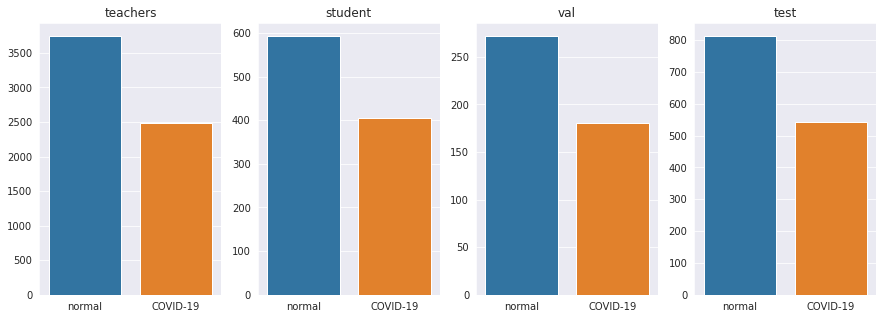

In [32]:
plot_distributions({'teachers': TEACHER_DISTRIBUTION, 'student': STUDENT_DISTRIBUTION, 'val': VAL_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [33]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [34]:
image_batch, label_batch = next(iter(teacher_batched[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


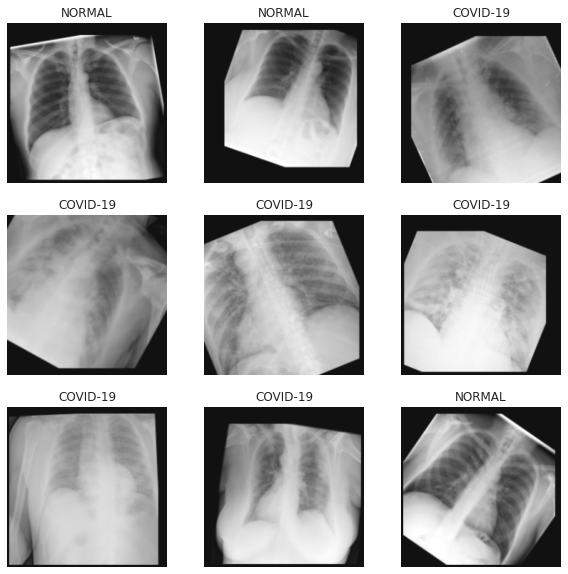

In [35]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [36]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [37]:
learning_rate_decay = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1, min_lr=1e-6)

## Teachers ResNet50
[Paper](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)

### Model definition

In [38]:
def resnet50_builder(weights=False, dropout=False, activation='relu', name='ResNet50'):
    # ResNet50 without head
    if activation == 'tanh':
        resnet50 = ResNet50_tanh(Input(shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2])))
    elif activation == 'relu':
        _weights = False if weights == 'pneumonia' else weights
        resnet50 = ResNet50(include_top = False,
                            weights = _weights,
                            input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]))
    
    resnet50.trainable = True # make layers trainable

    seq = [
        InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2]), name='Input'),
        resnet50, # add resnet50 to model
        GlobalAveragePooling2D(name='AvgPool'), # add last pooling layer
        Dense(units=1, activation='sigmoid', name='Output'), # add classification layer for normal/COVID-19
    ]

    if dropout:
        seq.insert(3, Dropout(rate=dropout, name='Dropout')) # add dropout (inspired by inception-resnet-v2))

    model = Sequential(seq, name=name)

    # load weights from pneumonia pretraining
    if weights == 'pneumonia' and activation == 'relu':
        model.load_weights(weights_path+'resnet50_relu_public_weights.h5', by_name=True)
    if weights == 'pneumonia' and activation == 'tanh':
        model.load_weights(weights_path+'resnet50_tanh_public_weights.h5', by_name=True)
    
    return model

In [39]:
METRICS = [
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

teacher_models = []
for teacher_id in range(TEACHER_NB):
    resnet50_teacher = resnet50_builder(weights='pneumonia', name='teacher-ResNet50-pneu')
    teacher_models.append(resnet50_teacher)
    teacher_models[teacher_id].compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [40]:
teacher_models[0].summary()

Model: "teacher-ResNet50-pneu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 7, 7, 2048)        23546057  
                                                                 
 AvgPool (GlobalAveragePooli  (None, 2048)             0         
 ng2D)                                                           
                                                                 
 Output (Dense)              (None, 1)                 2049      
                                                                 
Total params: 23,548,106
Trainable params: 23,502,532
Non-trainable params: 45,574
_________________________________________________________________


### Training

In [41]:
path = 'pate_teachers'+str(TEACHER_NB)+'_epochs'+str(TEACHER_EPOCHS)+'pneu_res50'
if SAVE_TEACHERS:
    if not os.path.exists(weights_path+path+'.zip'):
        os.mkdir(path)
        pbar = ProgressBar()
        teacher_histories = []
        for teacher_id in pbar(range(TEACHER_NB)):
            teacher_histories.append(teacher_models[teacher_id].fit(
                teacher_batched[teacher_id],
                steps_per_epoch=TEACHER_IMG_CNTS[teacher_id]//BATCH_SIZE,
                epochs=TEACHER_EPOCHS,
                validation_data=val_batched,
                validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
                class_weight=class_weight_dict,
                callbacks=[learning_rate_decay],
                verbose=0,
            ))
        pbar = ProgressBar()
        for teacher_id in pbar(range(TEACHER_NB)):
            # save weights
            teacher_models[teacher_id].save_weights(path+'/teacher_'+str(teacher_id)+'.h5')
        shutil.make_archive(weights_path+path, 'zip', path)
    else: # load weights
        pbar = ProgressBar()
        shutil.unpack_archive(weights_path+path+'.zip', path, 'zip')
        for teacher_id in pbar(range(TEACHER_NB)):
            teacher_models[teacher_id].load_weights(path+'/teacher_'+str(teacher_id)+'.h5')
else:
    pbar = ProgressBar()
    teacher_histories = []
    for teacher_id in pbar(range(TEACHER_NB)):
        teacher_histories.append(teacher_models[teacher_id].fit(
            teacher_batched[teacher_id],
            steps_per_epoch=TEACHER_IMG_CNTS[teacher_id]//BATCH_SIZE,
            epochs=TEACHER_EPOCHS,
            validation_data=val_batched,
            validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
            class_weight=class_weight_dict,
            callbacks=[learning_rate_decay],
            verbose=0,
        ))

100% (25 of 25) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


### Evaluation on test set

In [42]:
pbar = ProgressBar()
accs = []
for teacher_id in pbar(range(TEACHER_NB)):
    loss, acc, prec, rec = teacher_models[teacher_id].evaluate(test_batched, verbose=0)
    accs.append(acc)
print('Average teacher accuracy: %0.4f'%(np.mean(accs)))

100% (25 of 25) |########################| Elapsed Time: 0:01:53 Time:  0:01:53


Average teacher accuracy: 0.7847


## Aggregate student dataset

In [43]:
def ensemble_preds(nb_teachers, data):
  # Compute shape of array that will hold probabilities produced by each
  # teacher, for each training point, and each output class
  result_shape = (nb_teachers, len(data))
  # Create array that will hold result
  result = np.zeros(result_shape, dtype=np.float32)

  # Get predictions from each teacher
  pbar = ProgressBar()
  for teacher_id in pbar(range(nb_teachers)):
    # Get predictions on our training data and store in result array
    result[teacher_id] = [pred[0] for pred in teacher_models[teacher_id].predict(data, verbose=0)]

  return result

In [44]:
# get teacher predictions
with tf.device("/cpu:0"):
    teacher_preds = ensemble_preds(TEACHER_NB, student_data)
# turn probs into labels
teacher_preds = np.asarray(np.round(teacher_preds), dtype=np.int32)

100% (25 of 25) |########################| Elapsed Time: 0:50:53 Time:  0:50:53


In [45]:
def aggregate_noisy_max(preds, lap_scale):
  preds = preds.T
  labels = []
  for pred in preds:
    label_count = np.bincount(pred, minlength = 2)
    # convert to float for laplace
    label_count = np.asarray(label_count, dtype=np.float32)
    for i in range(len(label_count)):
      label_count[i] += np.random.laplace(loc=0.0, scale=lap_scale)
    noisy_labels = np.argmax(label_count)
    labels.append(noisy_labels)

  labels = np.asarray(labels, dtype=np.int32)
  return labels

In [46]:
# aggregate and add noise
aggregated_labels = aggregate_noisy_max(teacher_preds, NOISE_SCALE)

In [47]:
# test ensemble accuracy
assert len(aggregated_labels) == len(student_labels)
# Check against correct labels to compute correct guesses
correct = np.sum(aggregated_labels == student_labels)
# Divide by number of labels to obtain accuracy
agg_acc = float(correct) / len(student_labels)
print("Accuracy of the aggregated labels: %.4f"%(agg_acc))

Accuracy of the aggregated labels: 0.6096


In [48]:
student_aggregated_ds = tf.data.Dataset.from_tensor_slices((student_data, aggregated_labels))
student_aggregated_batched = prepare_dataset(student_aggregated_ds,
                                             pre=False,
                                             shuffle=False,
                                             repeat=True,
                                             augment=True,
                                             batch=True,
                                             cache='./data.tfcache_agg')

## Student ResNet50
[Paper](https://scholar.google.com/scholar?cluster=9281510746729853742&hl=en&as_sdt=0,5)

### Model definition

In [49]:
student = resnet50_builder(weights='pneumonia', name='student-ResNet50-oneu')

student.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=METRICS
)

### Training

In [50]:
history_student = student.fit(
    student_aggregated_batched,
    steps_per_epoch=STUDENT_IMG_COUNT//BATCH_SIZE,
    epochs=STUDENT_EPOCHS,
    validation_data=val_batched,
    validation_steps=VAL_IMG_COUNT//BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Epoch 1/20
31/31 [==============================] - 20s 423ms/step - loss: 0.7827 - accuracy: 0.5312 - precision: 0.7281 - recall: 0.7140 - val_loss: 1717.1348 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 11s 353ms/step - loss: 0.7118 - accuracy: 0.5292 - precision: 0.5015 - recall: 0.7228 - val_loss: 46.9036 - val_accuracy: 0.6027 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 11s 347ms/step - loss: 0.7027 - accuracy: 0.5665 - precision: 0.5328 - recall: 0.6915 - val_loss: 1.6651 - val_accuracy: 0.5982 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 11s 353ms/step - loss: 0.6826 - accuracy: 0.5716 - precision: 0.5334 - recall: 0.7792 - val_loss: 0.8408 - val_accuracy: 0.3929 - val_precision: 0.3946 - val_recall: 0.9888 - lr: 0.0010
Epoch 5/20
31/31 [==

## Evaluation

In [51]:
print("Evaluating %s ..." % (student.name))
loss, acc, prec, rec = student.evaluate(test_batched)
print('\n')

Evaluating student-ResNet50-oneu ...
43/43 [==============================] - 2s 57ms/step - loss: 0.6048 - accuracy: 0.7330 - precision: 0.6252 - recall: 0.8324




### Privacy Analysis

#### Compute epsilon

In [52]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [53]:
dde, die = perform_analysis(
    teacher_preds=teacher_preds,
    indices=aggregated_labels,
    noise_eps=NOISE_EPSILON,
    delta=DELTA,
    moments=20,
    beta=0.09
)
print("Data dependent epsilon = ", dde)
print("Data independent epsilon = ", die)

Data dependent epsilon =  10.109302417392959
Data independent epsilon =  10.10930241739305


#### Membership Inference Attack

In [54]:
def compute_attack_inputs(model, attack_data):
    bc = tf.keras.backend.binary_crossentropy
    constant = tf.keras.backend.constant
    # get labels
    labels = []
    for x, y in attack_data.as_numpy_iterator():
        labels.append(y[0])
    # predict
    probs = model.predict(attack_data)
    # compute loss
    losses = np.array([x[0] for x in bc(constant([[y] for y in labels]), constant(probs), from_logits=False).numpy()])
    
    return (np.array(probs), np.array(losses), np.array(labels))

# run membership inference attack
def run_mia(model, train_attack_input, test_attack_input):
    # prepare attacks
    probs_train, loss_train, labels_train = train_attack_input
    probs_test, loss_test, labels_test = test_attack_input

    attack_input = AttackInputData(
        probs_train = probs_train,
        probs_test = probs_test,
        loss_train = loss_train,
        loss_test = loss_test,
        labels_train = labels_train,
        labels_test = labels_test
    )

    slicing_spec = SlicingSpec(
        entire_dataset = True,
        by_class = True,
        by_percentiles = False,
        by_classification_correctness = True
    )

    attack_types = [
        #AttackType.THRESHOLD_ATTACK, # logistic was always better, so no threshold to save time
        AttackType.LOGISTIC_REGRESSION,
    ] 

    # run several attacks for different data slices
    attacks_result = mia.run_attacks(attack_input=attack_input,
                                     slicing_spec=slicing_spec,
                                     attack_types=attack_types)

    # plot the ROC curve of the best classifier
    #plotting.plot_roc_curve(attacks_result.get_result_with_max_auc().roc_curve)
    #plt.show()

    # print a user-friendly summary of the attacks
    #print(attacks_result.summary(by_slices=False))

    max_auc = attacks_result.get_result_with_max_auc().get_auc()
    max_adv = attacks_result.get_result_with_max_attacker_advantage().get_attacker_advantage()

    return max_auc, max_adv

# epsilon estimation based on attack, metric adapted for AUC from https://paperswithcode.com/paper/antipodes-of-label-differential-privacy-pate
def empirical_eps(auc):
    if auc <= 0.5:
        return 0
    if auc == 1:
        return np.inf
    return np.log(auc / (1 - auc))

from contextlib import contextmanager
import sys
@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [55]:
import scipy.stats as st

print('Membership Inference Attack on '+student.name+'...')
SAMPLE_NB = 100

train_attack_input = compute_attack_inputs(student, train_attack_data)
test_attack_input = compute_attack_inputs(student, test_attack_data)

aucs = []
advs = []
emp_eps = []
for i in range(SAMPLE_NB):
    with suppress_stdout():
        max_auc, max_adv = run_mia(student, train_attack_input, test_attack_input)
    aucs.append(max_auc)
    advs.append(max_adv)
    emp_eps.append(empirical_eps(max_auc))

auc_low, auc_high = st.t.interval(0.95, len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
adv_low, adv_high = st.t.interval(0.95, len(advs)-1, loc=np.mean(advs), scale=st.sem(advs))
eps_low, eps_high = st.t.interval(0.95, len(emp_eps)-1, loc=np.mean(emp_eps), scale=st.sem(emp_eps))

print('95%%-CI based on %i attack samples'%(SAMPLE_NB))
print('AUC: %0.2f-%0.2f'%(auc_low, auc_high))
print('Attacker advantage: %0.2f-%0.2f'%(adv_low, adv_high))
print('Empirical epsilon bounds from AUC: %0.2f-%0.2f\n'%(eps_low, eps_high))

Membership Inference Attack on student-ResNet50-oneu...
95%-CI based on 100 attack samples
AUC: 0.52-0.53
Attacker advantage: 0.12-0.13
Empirical epsilon bounds from AUC: 0.10-0.13

